In [1]:
from utils import preprocessing as pre
import tensorflow as tf
from utils import models
import matplotlib.pyplot as plt

In [2]:
file_path = '/mnt/Archive/Data_Sets/OGT'
file_name = 'ogt.fasta'

data = pre.prepare_dataset(file_path, file_name, file_format = 'fasta', seq_length = 1024, t_v_split = 0.1,start_stop = True, max_samples = 50000)


In [3]:
from utils import models

vocab = 23
n_filters = 64
s_kernel  = 3
dilation = 1
rate = 0.1
emb_s = 10

model = models.AminoCNN(vocab, emb_s, n_filters, s_kernel, dilation, rate)

In [4]:
model.build(input_shape=(None,1024,))
model.summary()

Model: "amino_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  230       
_________________________________________________________________
amino_cnn__mod (AminoCNN_Mod multiple                  54848     
_________________________________________________________________
amino_cnn__mod_1 (AminoCNN_M multiple                  79040     
_________________________________________________________________
amino_cnn__mod_2 (AminoCNN_M multiple                  79040     
_________________________________________________________________
amino_cnn__mod_3 (AminoCNN_M multiple                  79040     
_________________________________________________________________
amino_cnn__mod_4 (AminoCNN_M multiple                  107712    
_________________________________________________________________
amino_cnn__mod_5 (AminoCNN_M multiple                  10

In [5]:
@tf.function  # Make it fast.
def train_on_batch(x, y, w, model, loss_fn, optimizer):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss = loss_fn(y, logits, w)
        loss = tf.reduce_mean(loss,axis=0)
        #loss += tf.reduce_mean(model.losses)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    loss = tf.reduce_mean(loss,axis=None)
    return logits, loss

@tf.function  # Make it fast.
def validate_on_batch(x, y, w, model, loss_fn):
    logits = model(x, training=False)
    loss = loss_fn(y, logits, w)
    loss = tf.reduce_mean(loss,axis=0)
    #loss += tf.reduce_mean(model.losses)
    loss = tf.reduce_mean(loss,axis=None)
    return logits, loss

In [6]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        self.k1 = (d_model - 1e-7)/warmup_steps
        self.k2 = self.k1/8
        
    def __call__(self, step):

        arg1 = self.k1*step + 1e-7
        arg2 = self.d_model - self.k1*step
        arg3 = self.d_model*1/4 -self.k2*step
        return tf.math.minimum(arg1, tf.math.maximum(arg2,arg3))


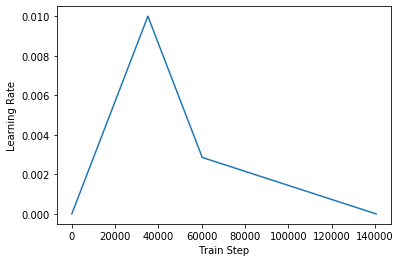

In [7]:
epochs = 200
steps = epochs *  45000/64

lr_schedule = CustomSchedule(0.02, steps/2)
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, label_smoothing=0.0,
    reduction = tf.keras.losses.Reduction.NONE,
    name='categorical_crossentropy'
)
acc = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')

plt.plot(lr_schedule(tf.range(steps, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [8]:
train_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
    
train_acc = tf.keras.metrics.CategoricalAccuracy()
val_acc   = tf.keras.metrics.CategoricalAccuracy()

for epoch in range(epochs):
    
    training_Batches = data[0].shuffle(1000000, reshuffle_each_iteration=True).batch(64)
    validation_Batches = data[1].shuffle(100000, reshuffle_each_iteration= True).batch(64)
    for step, (x, y, w) in enumerate(training_Batches):
        opt.lr.assign(lr_schedule(step*(epoch+1)))
        logits, loss = train_on_batch(x, y, w, model, loss_fn, opt)
        train_loss(loss)
        train_acc(y, logits, w)
        
    for step, (x, y, w) in enumerate(validation_Batches):
        logits, loss = validate_on_batch(x, y, w, model, loss_fn)
        
        val_loss(loss)
        val_acc(y, logits, w)
        
    print("Epoch: %d\tLoss%6.4f\tAcc%6.2f\tVal_loss%6.4f\tVal_acc%6.2f" % 
                      (epoch, train_loss.result().numpy(),                                                                       train_acc.result().numpy(),
                        val_loss.result().numpy(), 
                        val_acc.result().numpy()))
                  
    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()

Epoch: 0	Loss0.5292	Acc  0.65	Val_loss0.0066	Val_acc  1.00
Epoch: 1	Loss0.0157	Acc  1.00	Val_loss0.0001	Val_acc  1.00
Epoch: 2	Loss0.0032	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 3	Loss0.0012	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 4	Loss0.0005	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 5	Loss0.0003	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 6	Loss0.0001	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 7	Loss0.0001	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 8	Loss0.0000	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 9	Loss0.0000	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 10	Loss0.0000	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 11	Loss0.0000	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 12	Loss0.0000	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 13	Loss0.0000	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 14	Loss0.0000	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 15	Loss0.0000	Acc  1.00	Val_loss0.0000	Val_acc  1.00
Epoch: 16	Loss0.0000	Acc  1.00	Val_loss0.0000	Val_

KeyboardInterrupt: 